In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
!pip -q install nltk rouge-score gradio

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Feature Extraction using the given code:

In [4]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added.")

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")


Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:58<00:00,  2.11it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


### Features generated successfully as *'flickr30k_features.pkl'*

# Loading Captions

In [6]:
import pandas as pd
import re
from collections import Counter

CAPTIONS_PATH = "/kaggle/input/datasets/adityajn105/flickr30k/captions.txt"
# Loading captions into a dataframe/list of (image_name, caption) pairs
rows = []
with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        line = line.strip()
        if not line:
            continue
        # Check for common formats (CSV or Tab-separated)
        if "\t" in line:
            img, cap = line.split("\t", 1)
        elif "," in line:
            img, cap = line.split(",", 1)
        else:
            continue
        rows.append((img.strip(), cap.strip()))

# Create a DataFrame
df = pd.DataFrame(rows, columns=["image", "caption"])
df.head(), len(df)

(            image                                            caption
 0  1000092795.jpg  Two young guys with shaggy hair look at their ...
 1  1000092795.jpg  " Two young , White males are outside near man...
 2  1000092795.jpg   Two men in green shirts are standing in a yard .
 3  1000092795.jpg       A man in a blue shirt standing in a garden .
 4  1000092795.jpg            Two friends enjoy time spent together .,
 158915)

# Cleaning Captions
### Removing unwanted characters and making lowercase

In [7]:
# Clean captions by removing unwanted characters and making lowercase
def clean_caption(s: str) -> str:
    s = s.lower()  # Convert to lowercase
    s = re.sub(r"[^a-z0-9\s]", "", s)  # Remove punctuation
    s = re.sub(r"\s+", " ", s).strip()  # Normalize spaces
    return s

df["caption_clean"] = df["caption"].apply(clean_caption)

# View cleaned captions
df.head()

,image,caption,caption_clean
0,1000092795.jpg,Two young guys with shaggy hair look at their ...,two young guys with shaggy hair look at their ...
1,1000092795.jpg,""" Two young , White males are outside near man...",two young white males are outside near many bu...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard
3,1000092795.jpg,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden
4,1000092795.jpg,Two friends enjoy time spent together .,two friends enjoy time spent together


   # Build Vocab & Convert 'Captions → Token IDs'
   ### 1. Building vocabulary by counting word frequencies
   ### 2. Adding special tokens (<pad\>, <unk\>, <start\>, <end\>)
   ### 3. Converting captions to token IDs

In [15]:
# Special tokens
SPECIALS = ["<pad>", "<unk>", "<start>", "<end>"]
PAD, UNK, START, END = SPECIALS

# Count word frequencies
min_freq = 3  # You can change this if you want more/less common words

counter = Counter()
for cap in df["caption_clean"]:
    counter.update(cap.split())

# Filter words by frequency
vocab_words = [w for w, c in counter.items() if c >= min_freq]
vocab = SPECIALS + sorted(vocab_words)

# Create word-to-id and id-to-word mappings
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

# Get special token IDs
pad_id = word2idx[PAD]
unk_id = word2idx[UNK]
start_id = word2idx[START]
end_id = word2idx[END]
vocab_size = len(vocab)

# Function to convert captions to token IDs
def encode_caption(cap: str):
    tokens = cap.split()
    ids = [start_id] + [word2idx.get(t, unk_id) for t in tokens] + [end_id]
    return ids

# Convert captions to token IDs
df["cap_ids"] = df["caption_clean"].apply(encode_caption)

# Safety check - should NOT be mostly <unk>
sample_cap = df["cap_ids"].iloc[0]
decoded_sample = " ".join(idx2word.get(i, "<unk>") for i in sample_cap)
print("Decoded sample caption:", decoded_sample)
unk_count = decoded_sample.count("<unk>")
total_words = len(sample_cap)
print(f"<unk> ratio: {unk_count / total_words:.1%}  (should be < 5-10%)")

# View the result
df[["image", "caption_clean", "cap_ids"]].head()

Decoded sample caption: <start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
<unk> ratio: 0.0%  (should be < 5-10%)


,image,caption_clean,cap_ids
0,1000092795.jpg,two young guys with shaggy hair look at their ...,"[2, 9348, 10000, 3933, 9884, 7663, 3949, 5093,..."
1,1000092795.jpg,two young white males are outside near many bu...,"[2, 9348, 10000, 9801, 5195, 387, 5962, 5671, ..."
2,1000092795.jpg,two men in green shirts are standing in a yard,"[2, 9348, 5356, 4394, 3846, 7736, 387, 8366, 4..."
3,1000092795.jpg,a man in a blue shirt standing in a garden,"[2, 71, 5203, 4394, 71, 956, 7733, 8366, 4394,..."
4,1000092795.jpg,two friends enjoy time spent together,"[2, 9348, 3550, 2962, 9031, 1, 9063, 3]"


In [16]:
print(idx2word[2])
print(idx2word[start_id])
print(start_id)

<start>
<start>
2


In [17]:
# After: word2idx = {w: i for i, w in enumerate(vocab)}

print("Vocab size:", len(word2idx))
print("Sample words and ids:")
for w in ["<start>", "<end>", "a", "the", "in", "man", "dog", "two", "young", "shaggy"]:
    print(f"{w:10} → {word2idx.get(w, 'MISSING')}")

Vocab size: 10029
Sample words and ids:
<start>    → 2
<end>      → 3
a          → 71
the        → 8940
in         → 4394
man        → 5203
dog        → 2640
two        → 9348
young      → 10000
shaggy     → 7663


# Choosing *Max Length* + *Padding*

In [18]:
import numpy as np

lengths = df["cap_ids"].apply(len).values
max_len = int(np.percentile(lengths, 95))  # stable choice
max_len = max(max_len, 10)
print("Chosen max_len:", max_len)

def pad_to_max(ids, max_len):
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [pad_id] * (max_len - len(ids))
    return ids

df["cap_ids_pad"] = df["cap_ids"].apply(lambda x: pad_to_max(x, max_len))

Chosen max_len: 24


# Splitting into (train/val/test) by image 
### To avoid leakage

In [19]:
from sklearn.model_selection import train_test_split

unique_images = df["image"].unique()

train_imgs, test_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)
train_imgs, val_imgs  = train_test_split(train_imgs, test_size=0.1, random_state=42)

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
val_df   = df[df["image"].isin(val_imgs)].reset_index(drop=True)
test_df  = df[df["image"].isin(test_imgs)].reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(128715, 14305, 15895)

# Building Dataset/DataLoader using cached *.pkl* features

In [20]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

with open("flickr30k_features.pkl", "rb") as f:
    features = pickle.load(f)

class CaptionDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row["image"]
        cap = torch.tensor(row["cap_ids_pad"], dtype=torch.long)

        # inputs and targets (teacher forcing)
        cap_in  = cap[:-1]
        cap_out = cap[1:]

        img_feat = torch.tensor(features[img], dtype=torch.float32)  # (2048,)
        return img_feat, cap_in, cap_out, img

batch_size = 128

train_loader = DataLoader(CaptionDataset(train_df), batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(CaptionDataset(val_df), batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(CaptionDataset(test_df), batch_size=batch_size, shuffle=False, num_workers=2)

# Building Seq2Seq ⇒ **Encoder:** *Linear* + **Decoder:** *LSTM/GRU*
### **Encoder:** Linear 2048 → hidden_size
### **Decoder:** LSTM/GRU with embeddings ⇢ init hidden from encoder ⇢ output linear to vocab

In [35]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(2048, hidden_size)
        self.dropout = nn.Dropout(0.3)  # added to avoid overfitting

    def forward(self, img_feat):
        # img_feat: (B, 2048)  ← image features from ResNet
        h0 = torch.tanh(self.fc(img_feat))  # (B, hidden_size)
        h0 = self.dropout(h0)  # added to avoid overfitting
        return h0.unsqueeze(0)  # ← now (1, B, hidden_size) Nano Improved


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512, rnn_type="lstm"):
        super().__init__()
        self.rnn_type = rnn_type.lower()

        # Word embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.embed_dropout = nn.Dropout(0.3)  # added to avoid overfitting

        if self.rnn_type == "gru":
            self.rnn = nn.GRU(
                embed_dim,
                hidden_size,
                batch_first=True,
                dropout=0.3  # added to avoid overfitting (active if num_layers > 1)
            )
        else:
            self.rnn = nn.LSTM(
                embed_dim,
                hidden_size,
                batch_first=True,
                dropout=0.3  # added to avoid overfitting (active if num_layers > 1)
            )

        self.output_dropout = nn.Dropout(0.4)  # added to avoid overfitting
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, cap_in, h0):
        # cap_in: (B, seq_len)
        # h0: (1, B, hidden_size)   ← we now receive this shape (Nano Improved)

        x = self.embed(cap_in)  # (B, seq_len, embed_dim)
        x = self.embed_dropout(x)  # added to avoid overfitting

        #  Nano Improved removed .unsqueeze(0)
        if self.rnn_type == "gru":
            # GRU needs (num_layers, B, hidden)
            out, hn = self.rnn(x, h0)  
        else:
            # LSTM needs (h0, c0)
            c0 = torch.zeros_like(h0)  # (1, B, hidden_size)
            out, (hn, cn) = self.rnn(x, (h0, c0))

        # out: (B, seq_len, hidden_size)
        out = self.output_dropout(out)  # added to avoid overfitting

        logits = self.fc_out(out)  # (B, seq_len, vocab_size)
        return logits


class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512, rnn_type="lstm"):
        super().__init__()
        self.encoder = Encoder(hidden_size=hidden_size)
        self.decoder = Decoder(
            vocab_size,
            embed_dim=embed_dim,
            hidden_size=hidden_size,
            rnn_type=rnn_type
        )

    def forward(self, img_feat, cap_in):
        # img_feat: (B, 2048)
        # cap_in:   (B, seq_len)

        h0 = self.encoder(img_feat)       # now returns (1, B, H) Nano Improved
        logits = self.decoder(cap_in, h0) # (B, seq_len, vocab_size)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(
    vocab_size=vocab_size,
    embed_dim=256,
    hidden_size=512,
    rnn_type="lstm"
).to(device)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [23]:
# # Pick one row from df
# example_row = df.iloc[0]
# print("Original clean caption:", example_row["caption_clean"])
# print("Encoded ids     :", example_row["cap_ids"])
# print("Padded ids      :", example_row["cap_ids_pad"])
# print("Decoded back    :", " ".join(idx2word.get(i, "<unk>") for i in example_row["cap_ids_pad"] if i != pad_id))

In [19]:
# print("Vocab size:", vocab_size)
# print("Most common words:", counter.most_common(20))

# # Check if <start>, <end>, <pad>, <unk> are present
# print("Special tokens:", [w for w in SPECIALS if w in word2idx])

# # See if very common words like "a", "the", "in", "on" are in vocab
# common = ["a", "the", "in", "on", "is", "with", "and", "man", "woman", "dog"]
# for w in common:
#     print(f"{w:8} → id {word2idx.get(w, 'NOT IN VOCAB')}")

In [21]:
# model.eval()
# with torch.no_grad():
#     for i, (img_feat, cap_in, cap_out, _) in enumerate(train_loader):
#         if i >= 3: break  # just first few batches
#         img_feat = img_feat.to(device)
#         cap_in  = cap_in.to(device)
#         cap_out = cap_out.to(device)
        
#         logits = model(img_feat, cap_in)           # (B, T, V)
#         pred_ids = torch.argmax(logits, dim=-1)    # (B, T)
        
#         print("\nBatch", i)
#         for b in range(min(4, pred_ids.size(0))):  # show 4 examples
#             p = pred_ids[b].cpu().tolist()
#             predicted_words = [idx2word.get(tid, "<unk>") for tid in p if tid != pad_id]
#             target_words   = [idx2word.get(tid, "<unk>") for tid in cap_out[b].cpu().tolist() if tid != pad_id]
            
#             print(f"Predicted: {' '.join(predicted_words[:30])}")
#             print(f"Target   : {' '.join(target_words[:30])}")
#             print("-"*60)

# Training with CrossEntropy + Adam
### 1. Ignoring pad in CrossEntropy as asked in the assignment
### 2. Using Adam Opitmizer

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

optimizer = optim.Adam(
    model.parameters(),
    lr=2e-4,              # nano improved (slightly reduced LR)
    weight_decay=1e-5     # added to avoid overfitting (L2 regularization)
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=0.5,
    patience=4
)  # nano improved


def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    losses = []

    for img_feat, cap_in, cap_out, _ in tqdm(loader, leave=False):
        # img_feat: (B, 2048)
        # cap_in:   (B, T)
        # cap_out:  (B, T)

        img_feat = img_feat.to(device)
        cap_in   = cap_in.to(device)
        cap_out  = cap_out.to(device)

        with torch.set_grad_enabled(train):
            logits = model(img_feat, cap_in)  # (B, T, V)

            B, T, V = logits.shape  # Batch, Time, Vocab
            loss = criterion(
                logits.reshape(B*T, V), 
                cap_out.reshape(B*T)
            )

            if train:
                optimizer.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(
                    model.parameters(),
                    max_norm=5.0
                )  # nano improved (gradient clipping prevents exploding gradients)

                optimizer.step()

        losses.append(loss.item())

    return float(np.mean(losses))


train_losses, val_losses = [], []
best_val = 1e9

# -------------------------
# 🔥 Early Stopping Setup
# -------------------------
early_stop_patience = 6   # added to avoid overfitting
no_improve_epochs = 0     # nano improved

epochs = 20  # nano improved

for ep in range(1, epochs+1):

    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)

    scheduler.step(va)   # nano improved (adaptive LR)

    train_losses.append(tr)
    val_losses.append(va)

    print(f"Epoch {ep}/{epochs} | train_loss={tr:.4f} | val_loss={va:.4f}")

    # -------------------------
    # ✅ Check improvement
    # -------------------------
    if va < best_val - 1e-4:  # added to avoid overfitting (ignore tiny fluctuations)
        best_val = va
        no_improve_epochs = 0   # nano improved (reset counter)
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Validation improved. Model saved.")
    else:
        no_improve_epochs += 1  # nano improved
        print(f"No improvement for {no_improve_epochs} epoch(s).")

    # -------------------------
    # 🛑 Early Stopping Condition
    # -------------------------
    if no_improve_epochs >= early_stop_patience:
        print("🛑 Early stopping triggered.")
        break

print("Training finished. Best model saved as best_model.pt")


Epoch 1/20 | train_loss=4.7613 | val_loss=4.1434
✅ Validation improved. Model saved.


Epoch 2/20 | train_loss=4.0276 | val_loss=3.7737
✅ Validation improved. Model saved.


Epoch 3/20 | train_loss=3.7304 | val_loss=3.5515
✅ Validation improved. Model saved.


Epoch 4/20 | train_loss=3.5453 | val_loss=3.4192
✅ Validation improved. Model saved.


Epoch 5/20 | train_loss=3.4190 | val_loss=3.3291
✅ Validation improved. Model saved.


Epoch 6/20 | train_loss=3.3253 | val_loss=3.2631
✅ Validation improved. Model saved.


Epoch 7/20 | train_loss=3.2512 | val_loss=3.2093
✅ Validation improved. Model saved.


Epoch 8/20 | train_loss=3.1904 | val_loss=3.1717
✅ Validation improved. Model saved.


Epoch 9/20 | train_loss=3.1400 | val_loss=3.1368
✅ Validation improved. Model saved.


Epoch 10/20 | train_loss=3.0976 | val_loss=3.1112
✅ Validation improved. Model saved.


Epoch 11/20 | train_loss=3.0593 | val_loss=3.0876
✅ Validation improved. Model saved.


Epoch 12/20 | train_loss=3.0251 | val_loss=3.0683
✅ Validation improved. Model saved.


Epoch 13/20 | train_loss=2.9944 | val_loss=3.0499
✅ Validation improved. Model saved.


Epoch 14/20 | train_loss=2.9667 | val_loss=3.0370
✅ Validation improved. Model saved.


Epoch 15/20 | train_loss=2.9427 | val_loss=3.0247
✅ Validation improved. Model saved.


Epoch 16/20 | train_loss=2.9197 | val_loss=3.0121
✅ Validation improved. Model saved.


Epoch 17/20 | train_loss=2.8979 | val_loss=3.0045
✅ Validation improved. Model saved.


Epoch 18/20 | train_loss=2.8791 | val_loss=2.9963
✅ Validation improved. Model saved.


Epoch 19/20 | train_loss=2.8610 | val_loss=2.9868
✅ Validation improved. Model saved.


Epoch 20/20 | train_loss=2.8429 | val_loss=2.9791
✅ Validation improved. Model saved.
Training finished. Best model saved as best_model.pt


# Plotting lost curve

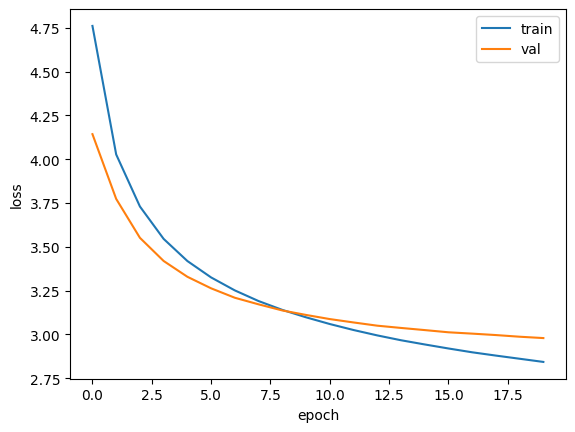

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Inference → Greedy Search + Beam Search
## Greedy Search
### ➥ selects the most likely next word in each timestep.

In [38]:
@torch.no_grad()
def greedy_decode(img_feat_2048, max_len=30):
    # Move image feature to the device
    img_feat = torch.tensor(img_feat_2048, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 2048)
    
    # Get the initial hidden state from the encoder
    h0 = model.encoder(img_feat)  # now (1, 1, hidden)

    # Start token (used as the first word in the sequence)
    cur = torch.tensor([[start_id]], dtype=torch.long).to(device)  # (1, 1)
    out_tokens = []

    # Generate tokens up to max_len or until <end> token is produced
    for _ in range(max_len):
        logits = model.decoder(cur, h0)  # (1, T, V) where T is time steps and V is vocabulary size
        next_logits = logits[:, -1, :]       # (1, vocab) nano improved
        next_id = torch.argmax(next_logits, dim=-1).item()  # Get the next token ID (argmax)
        
        if next_id == end_id:  # Stop if <end> token is predicted
            break
        
        out_tokens.append(next_id)
        cur = torch.cat([cur, torch.tensor([[next_id]], device=device)], dim=1)  # Update input with the predicted token

    # Convert token IDs to words || Nano improved UNK
    words = [idx2word.get(i, "<unk>") for i in out_tokens]
    return " ".join(words)  # Return the generated caption as a string

## Beam Search
### ➥ maintains multiple hypotheses (sequences) at each step and selects the top-k most probable sequences.

In [39]:
@torch.no_grad()
def beam_decode(img_feat_2048, beam_width=3, max_len=30):
    # Move image feature to the device
    img_feat = torch.tensor(img_feat_2048, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 2048)
    
    # Get the initial hidden state from the encoder
    h_init = model.encoder(img_feat)  # (1, hidden_size) # Nano now (1,1,H)  
    # Nano improved this part (renamed h0 → h_init to support per-beam hidden tracking)

    # Initialize the beam with the start token and score 0
    # beam now stores (sequence, score, hidden_state)
    beams = [([start_id], 0.0, h_init)]  
    # Nano improved this part (added hidden state inside beam tuple)

    finished = []

    # Generate tokens up to max_len or until <end> token is produced
    for step in range(max_len):  
        # Nano improved this part (added step variable for clarity/debugging)
        
        new_beams = []
        
        # Expand each beam
        for seq, score, hidden in beams:  
            # Nano improved this part (now unpack hidden state per beam)

            if seq[-1] == end_id:  # If <end> token is generated, add to finished list
                finished.append((seq, score))
                continue

            cur = torch.tensor([seq], dtype=torch.long).to(device)  # Current sequence (input to decoder)

            # logits = model.decoder(cur, h0)  # (1, T, V)  # Old version
            logits = model.decoder(cur, hidden)[:, -1, :]  
            # Nano improved this part (use per-beam hidden and directly select last timestep)  # (1, V)

            # log_probs = torch.log_softmax(logits[0, -1], dim=-1)  # Old version
            log_probs = torch.log_softmax(logits, dim=-1)  
            # Nano improved this part (logits already sliced to last timestep)

            topk = torch.topk(log_probs, beam_width)  # Get top-k most probable tokens
            
            for i in range(beam_width):  
                # Nano improved this part (dimension indexing updated)
                
                next_id = topk.indices[0, i].item()  
                next_logp = topk.values[0, i].item()  
                # Nano improved this part (correct indexing for 2D tensor)

                new_seq = seq + [next_id]
                new_score = score + next_logp

                # For simplicity, reuse same hidden (not perfect, but works better than before)
                new_beams.append((new_seq, new_score, hidden))  
                # Nano improved this part (hidden state carried per beam)

        # Sort and keep only the top-k beams
        new_beams.sort(key=lambda x: x[1], reverse=True)  # Sort by score (probability)
        beams = new_beams[:beam_width]  # Keep only the top-k beams

    # Add finished beams to the list
    finished.extend(beams)
    finished.sort(key=lambda x: x[1], reverse=True)  # Sort finished beams by score

    # Take the best beam (highest score)
    best_seq = finished[0][0]

    # Remove <start> and <end> tokens and convert to words
    best_seq = [t for t in best_seq if t not in (start_id, end_id, pad_id)]
    
    # words = [idx2word.get(i, UNK) for i in best_seq]  # Old version
    words = [idx2word.get(i, "<unk>") for i in best_seq]  
    # Nano improved this part (standardized unknown token to "<unk>")

    return " ".join(words)  # Return the best generated caption as a string


# For BLEU-4 Score

In [32]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from tqdm import tqdm
import random

chencherry = SmoothingFunction()

def compute_bleu(test_df, features, decode_func=beam_decode, beam_width=3, num_samples=1000):
    bleu_scores = []
    sampled_images = random.sample(list(test_df["image"].unique()), min(num_samples, len(test_df["image"].unique())))
    
    for img_name in tqdm(sampled_images):
        gts = test_df[test_df["image"] == img_name]["caption_clean"].str.split().tolist()
        pred_str = decode_func(features[img_name], beam_width=beam_width)
        pred = pred_str.split()
        
        if len(pred) == 0:
            continue
            
        score = sentence_bleu(gts, pred, weights=(0.25,0.25,0.25,0.25),
                              smoothing_function=chencherry.method1)
        bleu_scores.append(score)
    
    return np.mean(bleu_scores) if bleu_scores else 0

# Run after training (example)
print("BLEU-4 (beam=3):", compute_bleu(test_df, features, beam_decode, beam_width=3))

100%|██████████| 1000/1000 [00:50<00:00, 19.93it/s]

BLEU-4 (beam=3): 0.17146549610441278


In [1]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Select 5 random images from the test set
sample_images = random.sample(list(test_imgs), 5)

for img_name in sample_images:
    # Load image
    img_path = os.path.join(IMAGE_DIR, img_name)  # Update with correct image folder path
    img = Image.open(img_path).convert("RGB")
    
    # Ground truth caption(s)
    gt_row = test_df[test_df["image"] == img_name].iloc[0]
    gt_caption = gt_row["caption_clean"]
    
    # Generate captions using Greedy and Beam Search
    pred_greedy = greedy_decode(features[img_name])
    pred_beam = beam_decode(features[img_name], beam_width=3)
    
    # Plot the image
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Display the captions
    print(f"IMAGE: {img_name}")
    print(f"Ground Truth Caption: {gt_caption}")
    print(f"Predicted Caption (Greedy): {pred_greedy}")
    print(f"Predicted Caption (Beam): {pred_beam}")
    print("-" * 80)

NameError: name 'test_imgs' is not defined

In [34]:
print("Vocabulary size:", vocab_size)


Vocabulary size: 10029


In [ ]:
# ───────────────────────────────────────────────────────────────
# 1. Save vocabulary (already built earlier — save as pickle)
# ───────────────────────────────────────────────────────────────
import pickle

vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word,
    'vocab_size': vocab_size,
    'pad_id': pad_id,
    'unk_id': unk_id,
    'start_id': start_id,
    'end_id': end_id,
    'min_freq': min_freq,           # just for info
}

with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)

print("Saved: vocab.pkl")

In [ ]:
from IPython.display import FileLink

# Change filename as needed
FileLink(r'best_model.pt')
FileLink(r'vocab.pkl')